# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='hUv6aEy.jpeg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='q2P65L5.png' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='YVpIGGE.jpeg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from math import log
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

data = pd.read_csv('preprocessed_data.csv', nrows = 100000)

In [3]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [4]:
print(f'Input data shape : {data.shape[0]} rows and {data.shape[1]} columns/dimentions')

Input data shape : 100000 rows and 9 columns/dimentions


In [5]:
print('Column names are :', list(data.columns))

Column names are : ['school_state', 'teacher_prefix', 'project_grade_category', 'teacher_number_of_previously_posted_projects', 'project_is_approved', 'clean_categories', 'clean_subcategories', 'essay', 'price']


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [6]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [7]:
# Split the dataset 

y_data = data['project_is_approved'].values
x_data = data.drop(['project_is_approved'], axis =1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, stratify = y_data)
'''using GridSearch / RandomSearchCV, so not splitting into CrossValidation data'''

'using GridSearch / RandomSearchCV, so not splitting into CrossValidation data'

<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [8]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Title' (Optional)

'''min_df & max_df : https://stackoverflow.com/a/35615151'''
bow_vectorizer_essay = CountVectorizer(ngram_range =(1,4), min_df = 10, max_features = 10000)
bow_vectorizer_essay.fit(x_train['essay'].values)

x_train_essay_bow = bow_vectorizer_essay.transform(x_train['essay'].values)
x_test_essay_bow = bow_vectorizer_essay.transform(x_test['essay'].values)

print('Shape after BagOfWords vectorizations :')
print('='*45)
print('Train Data\t:',x_train_essay_bow.shape,',',y_train.shape)
print('Test Data\t:',x_test_essay_bow.shape,',',y_test.shape)

Shape after BagOfWords vectorizations :
Train Data	: (75000, 10000) , (75000,)
Test Data	: (25000, 10000) , (25000,)


In [9]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)

'''
https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d

* TFIDF gives more weightage to the word that is rare in the corpus (all the documents).
* TFIDF provides more importance to the word that is more frequent in the document.
'''

tfidf_vectorizor_essay = TfidfVectorizer(min_df = 10, ngram_range = (1,4), max_features = 10000)
tfidf_vectorizor_essay.fit(x_train['essay'].values)
x_train_essay_tfidf = tfidf_vectorizor_essay.transform(x_train['essay'].values)
x_test_essay_tfidf = tfidf_vectorizor_essay.transform(x_test['essay'].values)

print('Shape after TF-IDF vectorizations :')
print('='*45)
print('Train Data\t:', x_train_essay_tfidf.shape,',',y_train.shape)
print('Test Data\t:', x_test_essay_tfidf.shape,',',y_test.shape)

Shape after TF-IDF vectorizations :
Train Data	: (75000, 10000) , (75000,)
Test Data	: (25000, 10000) , (25000,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [10]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().

''' https://stats.stackexchange.com/a/519081 '''

print('Vector Shapes after one-hot encoding are :')
print('(Categorical features)')
print('='*45)

# school_state
vectorizer_school_state = CountVectorizer(binary=True)
vectorizer_school_state.fit(x_train['school_state'].values)

x_train_school_state = vectorizer_school_state.transform(x_train['school_state'].values)
x_test_school_state = vectorizer_school_state.transform(x_test['school_state'].values)
print('School State\t\t: ',x_train_school_state.shape,',',x_test_school_state.shape)
# print(vectorizer_school_state.get_feature_names())  # Code to printfeature names alone

# teacher_prefix
vectorizer_teacher_prefix = CountVectorizer(binary=True)
vectorizer_teacher_prefix.fit(x_train['teacher_prefix'].values)

x_train_teacher_prefix = vectorizer_teacher_prefix.transform(x_train['teacher_prefix'].values)
x_test_teacher_prefix = vectorizer_teacher_prefix.transform(x_test['teacher_prefix'].values)
print('Teacher Prefix\t\t: ', x_train_teacher_prefix.shape,',',x_test_teacher_prefix.shape)
# print(vectorizer_teacher_prefix.get_feature_names())  # Code to printfeature names alone

# project_grade_category
vectorizer_project_grade = CountVectorizer(binary=True)
vectorizer_project_grade.fit(x_train['project_grade_category'].values)

x_train_project_grade = vectorizer_project_grade.transform(x_train['project_grade_category'].values)
x_test_project_grade = vectorizer_project_grade.transform(x_test['project_grade_category'].values)
print('Project Grades\t\t: ', x_train_project_grade.shape,',',x_test_project_grade.shape)
# print(vectorizer_project_grade.get_feature_names())  # Code to printfeature names alone

# clean_categories
vectorizer_clean_categories = CountVectorizer(binary=True)
vectorizer_clean_categories.fit(x_train['clean_categories'].values)

x_train_clean_categories = vectorizer_clean_categories.transform(x_train['clean_categories'].values)
x_test_clean_categories = vectorizer_clean_categories.transform(x_test['clean_categories'].values)
print('Project Categories\t: ', x_train_clean_categories.shape,',',x_test_clean_categories.shape)
# print(vectorizer_clean_categories.get_feature_names())  # Code to printfeature names alone

# clean_subcategories
vectorizer_clean_subcategories = CountVectorizer(binary=True)
vectorizer_clean_subcategories.fit(x_train['clean_subcategories'].values)

x_train_clean_subcategories = vectorizer_clean_subcategories.transform(x_train['clean_subcategories'].values)
x_test_clean_subcategories = vectorizer_clean_subcategories.transform(x_test['clean_subcategories'].values)
print('Project Subcategories\t: ', x_train_clean_subcategories.shape,',',x_test_clean_subcategories.shape)
# print(vectorizer_clean_subcategories.get_feature_names())  # Code to printfeature names alone

# Perform normalization of numerical features
'''
since we are giving only a single feature input so array.reshape(-1, 1)
https://youtu.be/2zP3wPy7huw?t=1276
'''
print('\nVector Shapes after one-hot encoding are :')
print('(Numerical features)')
print('='*45)
# price
normalizer_price = Normalizer()
normalizer_price.fit(x_train['price'].values.reshape(-1, 1))

x_train_price = normalizer_price.transform(x_train['price'].values.reshape(-1, 1))
x_test_price = normalizer_price.transform(x_test['price'].values.reshape(-1, 1))
print('Price\t\t\t: ', x_train_price.shape,',',x_test_price.shape)

# teacher_number_of_previously_posted_projects
normalizer_pervious_project = Normalizer()
normalizer_pervious_project.fit(x_train['teacher_number_of_previously_posted_projects']\
                                                        .values.reshape(-1, 1))

x_train_previous_projects = normalizer_pervious_project.transform(
                    x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
x_test_previous_projects = normalizer_pervious_project.transform(
                    x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

print('Previous Projects\t: ', x_train_previous_projects.shape,',',x_test_previous_projects.shape)

Vector Shapes after one-hot encoding are :
(Categorical features)
School State		:  (75000, 51) , (25000, 51)
Teacher Prefix		:  (75000, 5) , (25000, 5)
Project Grades		:  (75000, 4) , (25000, 4)
Project Categories	:  (75000, 9) , (25000, 9)
Project Subcategories	:  (75000, 30) , (25000, 30)

Vector Shapes after one-hot encoding are :
(Numerical features)
Price			:  (75000, 1) , (25000, 1)
Previous Projects	:  (75000, 1) , (25000, 1)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

#### Set 1

In [11]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# Stack up all the features using hstack() (BoW)
'''merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039'''
x_train_stack_bow = hstack((x_train_essay_bow, x_train_school_state, x_train_teacher_prefix, 
                        x_train_project_grade, x_train_clean_categories, x_train_clean_subcategories,
                        x_train_price, x_train_previous_projects)).tocsr()

x_test_stack_bow = hstack((x_test_essay_bow, x_test_school_state, x_test_teacher_prefix, 
                       x_test_project_grade, x_test_clean_categories, x_test_clean_subcategories,
                       x_test_price, x_test_previous_projects)).tocsr()

print('BoW stack train shape\t: ', x_train_stack_bow.shape)
print('BoW stack test shape\t: ', x_test_stack_bow.shape)

BoW stack train shape	:  (75000, 10101)
BoW stack test shape	:  (25000, 10101)


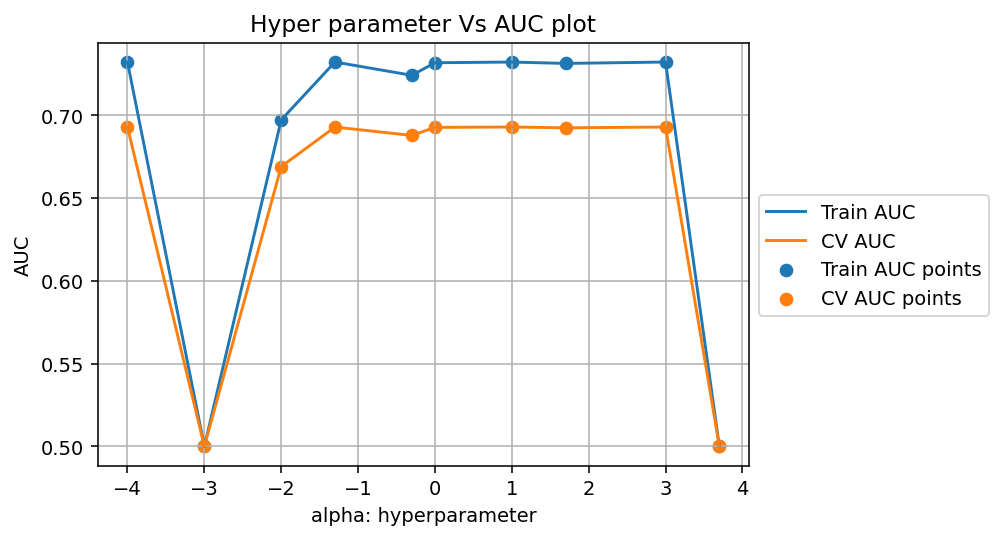

Best Hyper parameter =  {'alpha': 0.01}


In [12]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                       0.1, 0.5,1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

multi_NB = MultinomialNB(class_prior = [0.5, 0.5])

clf = RandomizedSearchCV(multi_NB, parameters, cv = 10, scoring = 'roc_auc',
                         return_train_score=True, n_jobs =-1)
'''
https://stackoverflow.com/a/57139639
KeyError: 'mean_train_score'
add, return_train_score = True
'''

search = clf.fit(x_train_stack_bow, y_train)

# https://stackoverflow.com/a/48803361/4084039

train_auc = search.cv_results_['mean_train_score']
train_auc_std = search.cv_results_['std_train_score']
cv_auc = search.cv_results_['mean_test_score']
cv_auc_std = search.cv_results_['std_test_score']
alphas = sorted(search.cv_results_['param_alpha'])

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
best_params_bow = search.best_params_

# fig = plt.figure(dpi=140)
# plt.plot(alphas, train_auc, label='Train AUC')
# plt.plot(alphas, cv_auc, label='CV AUC')
# plt.scatter(alphas, train_auc, label='Train AUC points')
# plt.scatter(alphas, cv_auc, label='CV AUC points')

#taking log for 'alphas', because data points are far away from each other
# https://docs.python.org/3.3/library/math.html#math.log
log_alphas = [log(value,10) for value in alphas]

fig = plt.figure(dpi=140)
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5)) #https://stackoverflow.com/a/4701285
plt.grid()
plt.show()
print('Best Hyper parameter = ', best_params_bow)

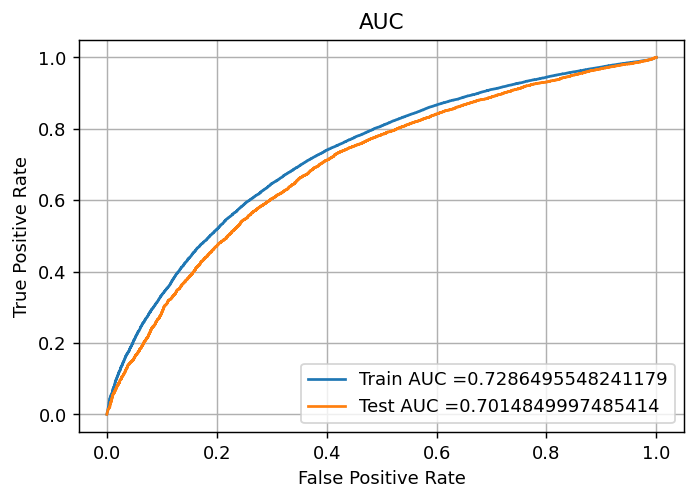

In [13]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
multi_NB_tuned_bow = MultinomialNB(class_prior = [0.5, 0.5], alpha = best_params_bow['alpha'])
multi_NB_tuned_bow.fit(x_train_stack_bow, y_train)

# https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/3
y_train_bow_pred = multi_NB_tuned_bow.predict_proba(x_train_stack_bow)[:,1]
y_test_bow_pred = multi_NB_tuned_bow.predict_proba(x_test_stack_bow)[:,1]

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_bow_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_bow_pred)

auc_train_set1 = auc(train_fpr, train_tpr)
auc_test_set1 = auc(test_fpr, test_tpr)

# 5_Reference_SampleSolution
plt.figure(dpi =130)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc_train_set1))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_test_set1))

# https://youtu.be/5e1vO6AwoQw?t=44
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.grid()
plt.legend(loc=4)
plt.show()

Train
=====
The maximum value of tpr*(1-fpr) 0.4536711932336976 for threshold 0.471

Test
====
The maximum value of tpr*(1-fpr) 0.43009945138291306 for threshold 0.376


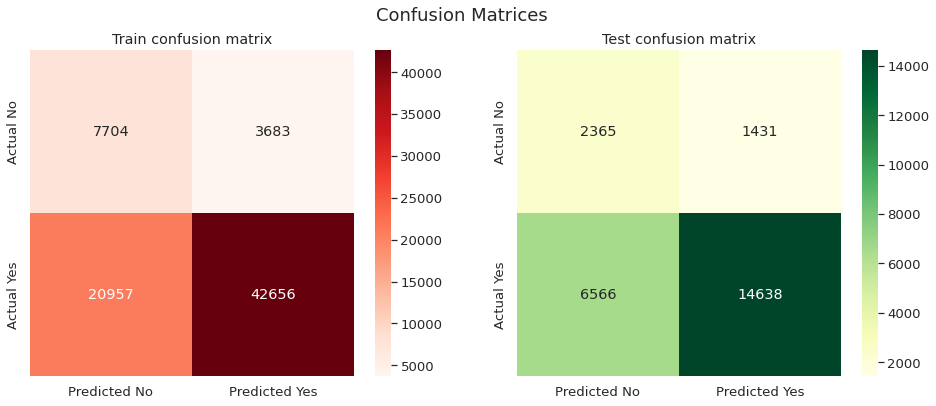

In [14]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

# we are writing our own function for predict, with defined thresould
def best_threshold_and_y_pred(threshould,proba, fpr, tpr):
    best_t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(best_t,3))
    
    predictions = []
    for i in proba:
        if i >= best_t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print('Train')
print('=' * 5)
train_confusion_mat_bow = confusion_matrix(y_train, 
                        best_threshold_and_y_pred(tr_thresholds, y_train_bow_pred, train_fpr, train_tpr))
print('\nTest')
print('=' * 4)
test_confusion_mat_bow = confusion_matrix(y_test,
                        best_threshold_and_y_pred(te_thresholds, y_test_bow_pred, test_fpr, test_tpr))

# print('\nTrain confusion matrix : \n', train_confusion_mat)
# print('\nTest confusion matrix : \n', test_confusion_mat)

'''
https://stackoverflow.com/a/61748695
https://stackoverflow.com/a/39133654
'''
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.suptitle('Confusion Matrices', fontsize = 18)

fig_1 = sns.heatmap(train_confusion_mat_bow, annot=True, fmt="d", cmap='Reds', ax = axes[0])
fig_1.title.set_text('Train confusion matrix')
axes[0].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[0].set_yticklabels(['Actual No', 'Actual Yes'])

fig_2 = sns.heatmap(test_confusion_mat_bow, annot=True, fmt="d", cmap='YlGn', ax = axes[1])
fig_2.title.set_text('Test confusion matrix')
axes[1].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[1].set_yticklabels(['Actual No', 'Actual Yes'])

plt.show()

#### Set 2

In [15]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# Stack up all the features using hstack() (TF-IDF)
'''merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039'''
x_train_stack_tfidf  = hstack((x_train_essay_tfidf, x_train_school_state, x_train_teacher_prefix, 
                        x_train_project_grade, x_train_clean_categories, x_train_clean_subcategories,
                        x_train_price, x_train_previous_projects)).tocsr()

x_test_stack_tfidf = hstack((x_test_essay_tfidf, x_test_school_state, x_test_teacher_prefix, 
                       x_test_project_grade, x_test_clean_categories, x_test_clean_subcategories,
                       x_test_price, x_test_previous_projects)).tocsr()

print('\nTFIDF stack train shape\t: ',x_train_stack_tfidf.shape)
print('TFIDF stack test shape\t: ',x_test_stack_tfidf.shape)


TFIDF stack train shape	:  (75000, 10101)
TFIDF stack test shape	:  (25000, 10101)


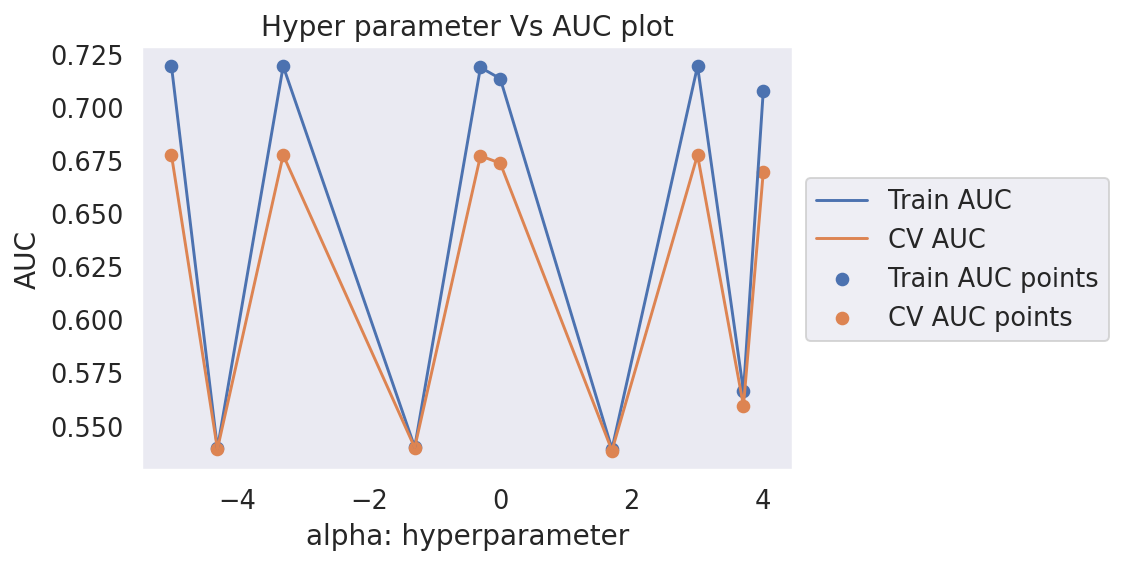

Best Hyper parameter =  {'alpha': 1e-05}


In [16]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training datafor this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                       0.1, 0.5,1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

multi_NB = MultinomialNB(class_prior = [0.5, 0.5])

clf = RandomizedSearchCV(multi_NB, parameters, cv = 10, scoring = 'roc_auc',
                         return_train_score=True, n_jobs =-1)
'''
https://stackoverflow.com/a/57139639
KeyError: 'mean_train_score'
add, return_train_score = True
'''

search = clf.fit(x_train_stack_tfidf, y_train)

# https://stackoverflow.com/a/48803361/4084039

train_auc = search.cv_results_['mean_train_score']
train_auc_std = search.cv_results_['std_train_score']
cv_auc = search.cv_results_['mean_test_score']
cv_auc_std = search.cv_results_['std_test_score']
alphas = sorted(search.cv_results_['param_alpha'])

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
best_params_tfidf = search.best_params_

# fig = plt.figure(dpi=140)
# plt.plot(alphas, train_auc, label='Train AUC')
# plt.plot(alphas, cv_auc, label='CV AUC')
# plt.scatter(alphas, train_auc, label='Train AUC points')
# plt.scatter(alphas, cv_auc, label='CV AUC points')

#taking log for 'alphas', because data points are far away from each other
# https://docs.python.org/3.3/library/math.html#math.log
log_alphas = [log(value,10) for value in alphas]

fig = plt.figure(dpi=140)
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5)) #https://stackoverflow.com/a/4701285
plt.grid()
plt.show()
print('Best Hyper parameter = ', best_params_tfidf)

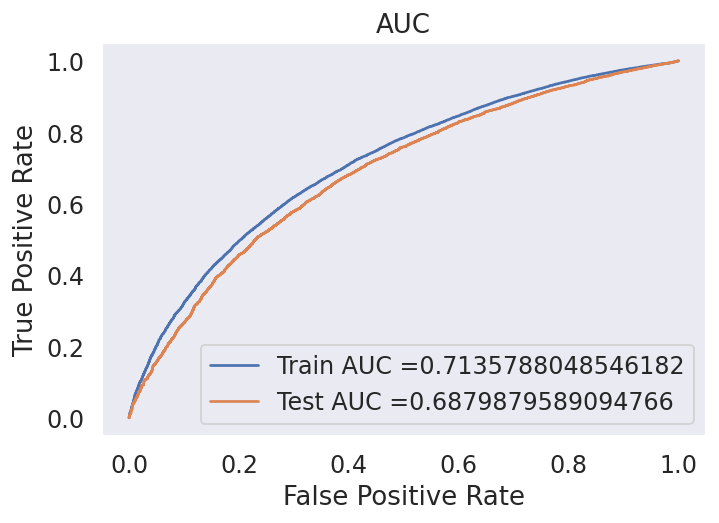

In [17]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.

# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
multi_NB_tuned_tfidf = MultinomialNB(class_prior = [0.5, 0.5], alpha = best_params_tfidf['alpha'])
multi_NB_tuned_tfidf.fit(x_train_stack_tfidf, y_train)

# https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376/3
y_train_tfidf_pred = multi_NB_tuned_bow.predict_proba(x_train_stack_tfidf)[:,1]
y_test_tfidf_pred = multi_NB_tuned_bow.predict_proba(x_test_stack_tfidf)[:,1]

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_tfidf_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_tfidf_pred)

auc_train_set2 = auc(train_fpr, train_tpr)
auc_test_set2 = auc(test_fpr, test_tpr)

# 5_Reference_SampleSolution
plt.figure(dpi =130)
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc_train_set2))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc_test_set2))

# https://youtu.be/5e1vO6AwoQw?t=44
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.grid()
plt.legend(loc=4)
plt.show()

Train
=====
The maximum value of tpr*(1-fpr) 0.4340146000994357 for threshold 0.44

Test
====
The maximum value of tpr*(1-fpr) 0.4118585892198004 for threshold 0.434


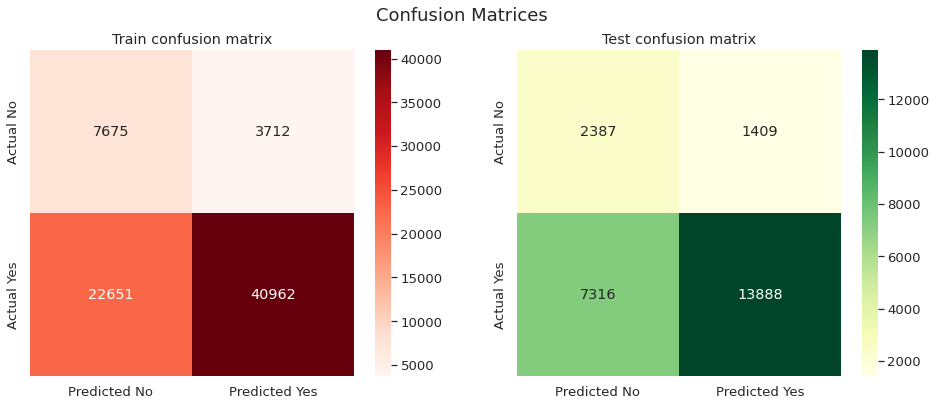

In [18]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

# we are writing our own function for predict, with defined thresould
def best_threshold_and_y_pred(threshould,proba, fpr, tpr):
    best_t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(best_t,3))
    
    predictions = []
    for i in proba:
        if i >= best_t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print('Train')
print('=' * 5)
train_confusion_mat_tfidf = confusion_matrix(y_train, 
                    best_threshold_and_y_pred(tr_thresholds, y_train_tfidf_pred, train_fpr, train_tpr))
print('\nTest')
print('=' * 4)
test_confusion_mat_tfidf = confusion_matrix(y_test,
                    best_threshold_and_y_pred(te_thresholds, y_test_tfidf_pred, test_fpr, test_tpr))

# print('\nTrain confusion matrix : \n', train_confusion_mat)
# print('\nTest confusion matrix : \n', test_confusion_mat)

'''
https://stackoverflow.com/a/61748695
https://stackoverflow.com/a/39133654
'''
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1, 2, figsize = (16,6))
fig.suptitle('Confusion Matrices', fontsize = 18)

fig_1 = sns.heatmap(train_confusion_mat_tfidf, annot=True, fmt="d", cmap='Reds', ax = axes[0])
fig_1.title.set_text('Train confusion matrix')
axes[0].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[0].set_yticklabels(['Actual No', 'Actual Yes'])

fig_2 = sns.heatmap(test_confusion_mat_tfidf, annot=True, fmt="d", cmap='YlGn', ax = axes[1])
fig_2.title.set_text('Test confusion matrix')
axes[1].set_xticklabels(['Predicted No', 'Predicted Yes'])
axes[1].set_yticklabels(['Actual No', 'Actual Yes'])

plt.show()

In [19]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the
# positive and negative classes each. (You have to print the names of the features, but not the indexes)

'''
Extracting feature names in the same order as hstack list

x_train_stack_bow = hstack((x_train_essay_bow, x_train_school_state, x_train_teacher_prefix, 
                        x_train_project_grade, x_train_clean_categories, x_train_clean_subcategories,
                        x_train_price, x_train_previous_projects)).tocsr()

x_train_stack_tfidf  = hstack((x_train_essay_tfidf, x_train_school_state, x_train_teacher_prefix, 
                        x_train_project_grade, x_train_clean_categories, x_train_clean_subcategories,
                        x_train_price, x_train_previous_projects)).tocsr()
'''

all_bow_vectorizer = [bow_vectorizer_essay, vectorizer_school_state, vectorizer_teacher_prefix,
                vectorizer_project_grade,vectorizer_clean_categories, vectorizer_clean_subcategories]

all_tfidf_vectorizer = [tfidf_vectorizor_essay, vectorizer_school_state, vectorizer_teacher_prefix,
                vectorizer_project_grade,vectorizer_clean_categories, vectorizer_clean_subcategories]

# Initializing lists to store feature names
bow_all_feature_names = []
tfidf_all_feature_names = []

#Iterating over the list to generate all feature names on BoW
for vec in tqdm(all_bow_vectorizer):
    for i in tqdm(vec.get_feature_names()):
        bow_all_feature_names.append(i)
bow_all_feature_names.append('price')
bow_all_feature_names.append('pervious_project')
print('Length of BoW feature name list\t\t:',len(bow_all_feature_names))

#Iterating over the list to generate all feature names on TFIDF
for vec in all_tfidf_vectorizer:
    for i in vec.get_feature_names():
        tfidf_all_feature_names.append(i)
tfidf_all_feature_names.append('price')
tfidf_all_feature_names.append('pervious_project')
print('Length of TFIDF feature name list\t:',len(tfidf_all_feature_names))

print('\nLength of BoW feature name list & hstack-bow shape is same\t: ', 
                  len(bow_all_feature_names) == x_train_stack_bow.shape[1])
print('Length of TFIDF feature name list & hstack-bow shape is same\t: ', 
                  len(tfidf_all_feature_names) == x_train_stack_tfidf.shape[1])

'''
https://stackoverflow.com/q/61586946
print ((nb.feature_log_prob_)[2:3])
Extracting BoW feature_log_prob_ values
'''
# Positive Class
bow_features_prob_positive = {}

for index in range(len(bow_all_feature_names)):
    bow_features_prob_positive[index] = multi_NB_tuned_bow.feature_log_prob_[1,index]
    
positive_feature_df = pd.DataFrame({'feature_names': bow_all_feature_names, 
                                   'positive_proba_score': bow_features_prob_positive.values()})

#Sorting values based on positive_proba_score
positive_feature_df.sort_values(by = ['positive_proba_score'],  ascending = False, inplace = True)
# print(positive_feature_df.head(6))

# Negative Class
bow_features_prob_negative = {}

for index in range(len(bow_all_feature_names)):
    bow_features_prob_negative[index] = multi_NB_tuned_bow.feature_log_prob_[0,index]
    
negative_feature_df = pd.DataFrame({'feature_names': bow_all_feature_names, 
                                   'negative_proba_score': bow_features_prob_negative.values()})

#Sorting values based on negative_proba_score
negative_feature_df.sort_values(by = ['negative_proba_score'],  ascending = False, inplace = True)
# print(negative_feature_df.head(6))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Length of BoW feature name list		: 10101
Length of TFIDF feature name list	: 10101

Length of BoW feature name list & hstack-bow shape is same	:  True
Length of TFIDF feature name list & hstack-bow shape is same	:  True


In [20]:
print('Top 20 features associated with the positive class')
print('=' * 50)

for i in range(20):
    print(f"{positive_feature_df.iloc[i]['feature_names']:15} \
        {positive_feature_df.iloc[i]['positive_proba_score']}")

    
print('\n\nTop 20 features associated with the negative class')
print('=' * 50)

for i in range(20):
    print(f"{negative_feature_df.iloc[i]['feature_names']:15}\
        {negative_feature_df.iloc[i]['negative_proba_score']}")

Top 20 features associated with the positive class
students                -3.321912170441113
school                  -4.47055510688463
my                      -4.780781277775018
learning                -4.832905314233335
classroom               -4.85709924786995
the                     -5.078528424507208
not                     -5.125619557672026
they                    -5.127038726925562
my students             -5.157866978468489
learn                   -5.174901639522492
help                    -5.200736856123079
price                   -5.31478726374039
many                    -5.3419718524639705
nannan                  -5.363656809476916
we                      -5.400306335279703
work                    -5.473209783543606
need                    -5.47590251798276
reading                 -5.481774154572538
use                     -5.526800271736134
love                    -5.634928334537896


Top 20 features associated with the negative class
students               -3.3337073911162

<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [21]:
#Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.

# Reference Link for Pretty table:  https://pypi.org/project/prettytable/

x = PrettyTable()

x.field_names = ['Vectorizer', 'Model', 'Hyper Parameter', 'AUC (train)', 'AUC (test)']
x.add_row(['BoW', 'MultinomialNB', best_params_bow['alpha'], round(auc_train_set1,3),
                                                                        round(auc_test_set1,3)])
x.add_row(['TFIDF', 'MultinomialNB', best_params_tfidf['alpha'], round(auc_train_set2,3),
                                                                        round(auc_test_set2,3)])

print(x)

+------------+---------------+-----------------+-------------+------------+
| Vectorizer |     Model     | Hyper Parameter | AUC (train) | AUC (test) |
+------------+---------------+-----------------+-------------+------------+
|    BoW     | MultinomialNB |       0.01      |    0.729    |   0.701    |
|   TFIDF    | MultinomialNB |      1e-05      |    0.714    |   0.688    |
+------------+---------------+-----------------+-------------+------------+


<u>Summary</u>
* False negative count is almost half of ture positive counts (for both train and test datasets), which is not good
* The true negative count is very less in all case. The value is only ~20% of true positive count.
* There is no great difference in AUC (test) curves for BoW and TF-IDF models, both are  almost similar to each other.
* For AUC (train) there is a visible change or BoW and TF-IDF models.